In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Model,Sequential
from keras.layers import Dense,Embedding, Input , Activation
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import initializers, optimizers, layers
from sklearn.metrics import  roc_auc_score

import warnings
warnings.simplefilter(action="ignore")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSets/TCC/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DataSets/TCC/test.csv')

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
train['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[classes].values

train_sentences = train['comment_text']
test_sentences = test['comment_text']

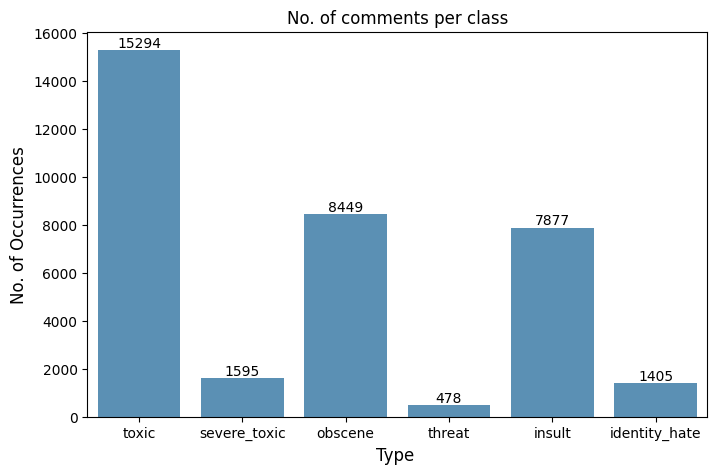

In [ ]:
value_counts = train[classes].sum()

plt.figure(figsize=(8,5))
ax = sns.barplot(x=value_counts.index, y=value_counts.values, alpha=0.8)

plt.title("No. of comments per class")
plt.ylabel('No. of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

rects = ax.patches
labels = value_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

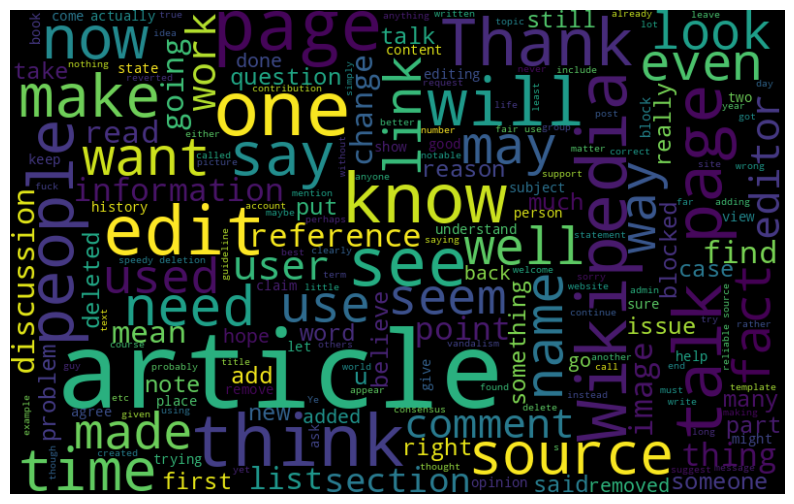

In [ ]:
from wordcloud import WordCloud

all_words = ' '.join([text for text in train['comment_text'] ])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
max_features = 22000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(train_sentences))

tokenized_train = tokenizer.texts_to_sequences(train_sentences)
tokenized_test = tokenizer.texts_to_sequences(test_sentences)

In [ ]:
maxlen = 200
X_train = pad_sequences(tokenized_train, maxlen = maxlen)
X_test = pad_sequences(tokenized_test, maxlen = maxlen)

In [ ]:
embed_size = 128
maxlen = 200
max_features = 22000

inp = Input(shape = (maxlen, ))
x = Embedding(max_features, embed_size)(inp)
x = LSTM(60, return_sequences=True, name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(6, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=inp, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 200, 128)            │       2,816,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_layer (LSTM)                    │ (None, 200, 60)             │          45,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 60)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │           3,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             306 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,864,716 (10.93 MB)

 Trainable params: 2,864,716 (10.93 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 64
epochs = 2
model.fit(X_train, targets, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.8203 - loss: 0.1173 - val_accuracy: 0.9940 - val_loss: 0.0528
Epoch 2/2
2244/2244 ━━━━━━━━━━━━━━━━━━━━ 35s 13ms/step - accuracy: 0.9912 - loss: 0.0466 - val_accuracy: 0.9940 - val_loss: 0.0503


In [ ]:
prediction = model.predict(X_test)
prediction

4787/4787 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step


array([[9.8957670e-01, 3.1906366e-01, 9.4252753e-01, 5.9644148e-02,
        8.2263792e-01, 2.1646726e-01],
       [2.6599548e-03, 1.3436228e-06, 2.2292569e-04, 1.0448419e-05,
        1.0043243e-04, 5.2082480e-05],
       [1.3187584e-03, 3.9607454e-07, 8.9450616e-05, 4.5365464e-06,
        3.7867503e-05, 2.0263573e-05],
       ...,
       [8.8491099e-04, 1.3933740e-07, 6.0642375e-05, 1.2752115e-06,
        2.0957299e-05, 1.0211923e-05],
       [2.1294276e-03, 4.7898703e-07, 1.4588900e-04, 4.1019689e-06,
        6.8613663e-05, 3.0862622e-05],
       [9.1733998e-01, 2.0795997e-02, 7.3764336e-01, 7.3016132e-03,
        4.1154456e-01, 4.4973250e-02]], dtype=float32)

In [ ]:
def classify_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences([comment])
    padded_comment = pad_sequences(tokenized_comment, maxlen=maxlen)
    prediction = model.predict(padded_comment)[0]
    classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    results = {c: float(p) for c, p in zip(classes, prediction)}
    return results

# Example usage
user_comment = input("Enter a comment: ")
classification_results = classify_comment(user_comment)
print("Comment classification:")
for label, score in classification_results.items():
    print(f"{label.capitalize()}: {score:.2f}")


Enter a comment: yoyu are not good
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Comment classification:
Toxic: 0.01
Severe_toxic: 0.00
Obscene: 0.00
Threat: 0.00
Insult: 0.00
Identity_hate: 0.00
